In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole_map, spherical_to_cartesian

### fit to CMB dipole

In [3]:
# Quaia map
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
map_quaia = tools.load_catalog_as_map(cat_fn, frame='icrs')

In [4]:
# selection function
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))

In [5]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(amps, NSIDE) # match NSIDE with Quaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


### fit to CMB dipole and feature maps

In [6]:
# design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree

In [7]:
# weights
"""
WARNING: "magic number"
"""
# ! OLD covariance
# Cinv = 42 * selfunc

Cinv = 1. / np.clip(42 * selfunc, 1., None)  # set min value to 1

In [8]:
maps_forsel = []
map_names = ['dust', 'stars', 'm10', 'mcs']
for map_name in map_names:
    maps_forsel.append(np.load(f'/scratch/aew492/quasars/maps/map_{map_name}_NSIDE{NSIDE}.npy'))

In [9]:
# construct design matrix
fit_everything = True
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 6)

In [10]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [11]:
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [12]:
x_names = np.append(['completeness','CMB dipole * comp.'], map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.043264       	0.042055        	
CMB dipole * comp.	71.929164       	8.422380        	
dust            	4.530e-03       	1.539e-03       	
stars           	1.996e-05       	8.600e-06       	
m10             	-5.606e-03      	7.691e-04       	
mcs             	1.388e-04       	1.738e-04       	


In [13]:
bestfit_pars[1]/bestfit_pars[0]

1.7525205476371122

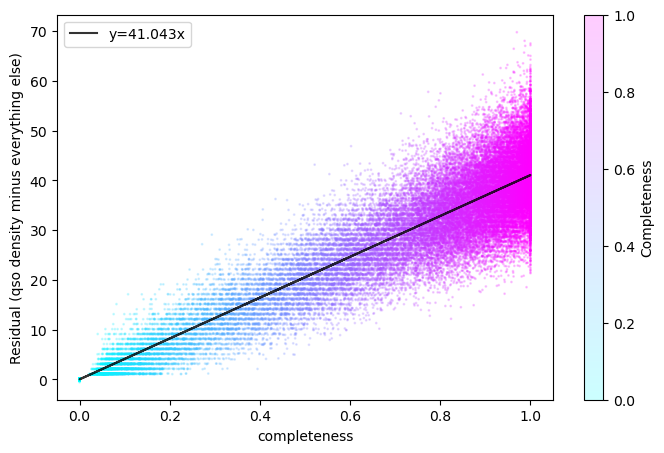

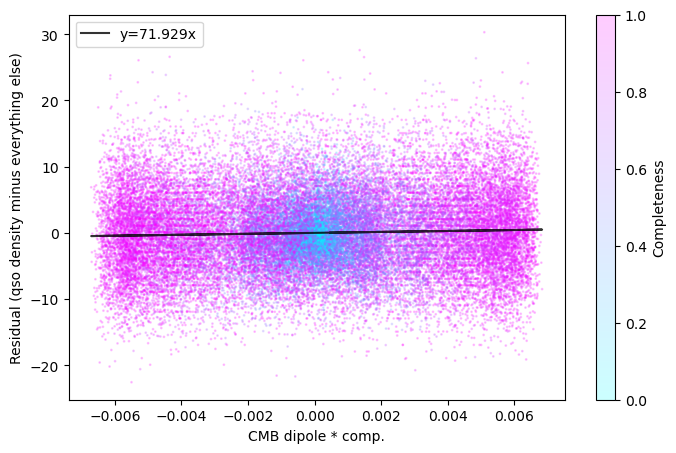

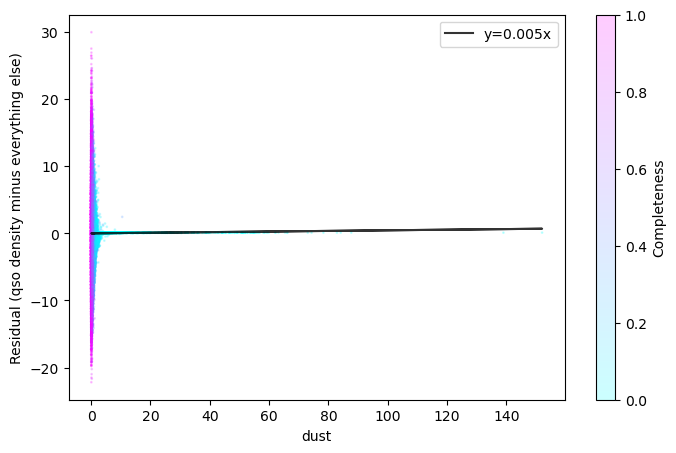

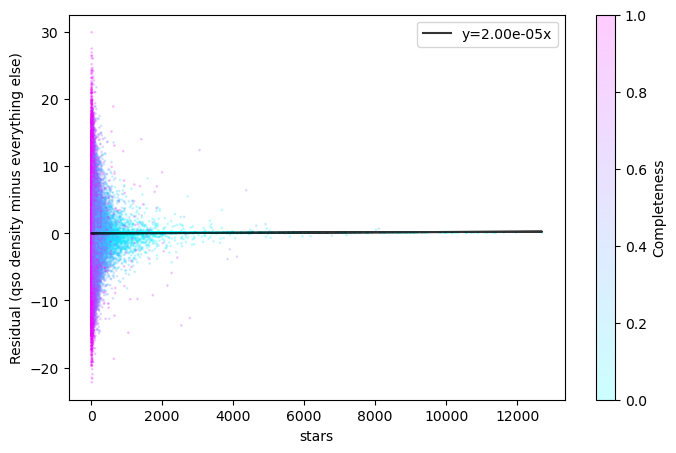

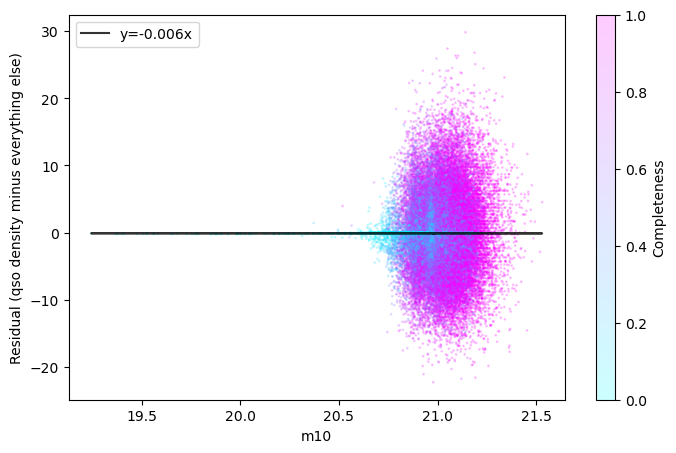

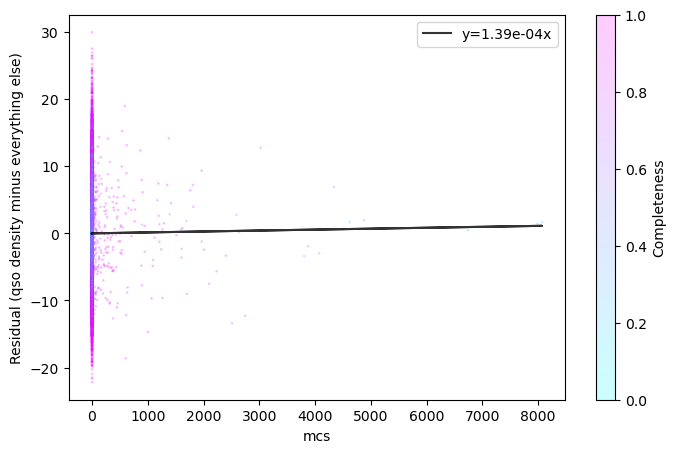

In [14]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    if x_names[i]=='stars' or x_names[i]=='mcs':
        label = f'y={slope:.2e}x'
    else:
        label = f'y={slope:.3f}x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend()
    fig.colorbar(s, label='Completeness')